In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
import nltk
import re
import string
from  bs4 import BeautifulSoup

#plotting techniques
import matplotlib.pyplot as plt
import seaborn as sns

#splitting data and evalution
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,precision_recall_curve,fbeta_score
from sklearn.metrics import roc_auc_score,roc_curve,f1_score,precision_score,recall_score,accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec,KeyedVectors

#algo.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier

#saving model
import pickle

#measure preformance
from tqdm import tqdm
import time

In [4]:
data = pd.read_csv("train.csv")

In [5]:
data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
data.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

We have no missing values

In [7]:
#Dropping duplicate entries
final = data.drop_duplicates(subset = ["comment_text"], keep ='first',inplace = False)
final.shape

(159571, 8)

## EDA

In [8]:
data_counts = data.iloc[:,2:].sum()
data_counts

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

Text(0, 0.5, 'Count')

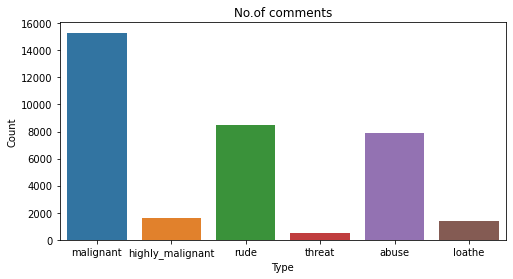

In [9]:
#plot chart with following size
plt.figure(figsize=(8,4))

ax=sns.barplot(data_counts.index,data_counts.values)

plt.title("No.of comments")
plt.xlabel("Type",fontsize=10)
plt.ylabel("Count",fontsize=10)

Data is imbalanced

#### Preprocessing

##### Preprocesing Review Text

This is the pre processing phase we do the following in order below:

1.Begin by removing html tags

2.Remove any panctuations or limited set of special characters like ,or,#," etc.


3.Check if the word is made up of english letter and is not aplhanumeric


4.Check if the length of word is less than 2(there is no adjective in 2 letters)


5.convert word to lower case letter


6.Remove stopwords


7.Finally Snowball stemming the word.

In [10]:
#printing random comments

cmt = final['comment_text'].values[0]
print(cmt)

print("==="*42)

cmt_1 = final['comment_text'].values[453]
print(cmt_1)

print("==="*42)

cmt_2 = final['comment_text'].values[853]
print(cmt_2)

print("==="*42)

cmt_3 = final['comment_text'].values[489]
print(cmt_3)

print("==="*42)

cmt_4 = final['comment_text'].values[914]
print(cmt_4)


print("==="*42)

cmt_5 = final['comment_text'].values[27]
print(cmt_5)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
2007 (UTC)

Has anyone considered how matter (the stuff we are all made from) actually interact with time and time travel? If I were to travel back in time, would I be 'frozen' and isolated in spacetime, whilst everything else around me travel backwards in time, or will I also physically and biologically travel back in time, that is I get younger and younger, and then disappear because I was not yet created, thus defeating the Grandfather Paradox? Although if it were possible for signals (or information) to travel backwards and forwards in time, does this possibility automatically extend to matter as we know it (ie particles giving rise to electrons, protons and neutrons, and ultimately biological beings such as ourselves)?  

In [11]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"aren\'t", "are not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase   

In [12]:
from nltk.corpus import stopwords

stop_words= set(stopwords.words('english'))

In [13]:
from tqdm import tqdm

processed_comments = []

for sentence in tqdm(final['comment_text'].values):
    sentence = re.sub(r"http\S+","",sentence)
    sentence = BeautifulSoup(sentence,'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*","",sentence).strip()
    sentence = re.sub('[^A-Za-z-0-9]+',' ',sentence)
    sentence = re.sub(r'[^\x00-\x7f]',r' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
    processed_comments.append(sentence.strip())

100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [03:31<00:00, 755.21it/s]


In [14]:
processed_comments[3]

'make real suggestions improvement - wondered section statistics later subsection types accidents -i think references may need tidying exact format ie date format etc later no-one else first - preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipedia good article nominations transport'

In [15]:
data.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
new_data = data.drop(["comment_text"],axis=1)
new_data['processed_comments'] = processed_comments

In [17]:
new_data.head(5)

,id,malignant,highly_malignant,rude,threat,abuse,loathe,processed_comments
0,0000997932d777bf,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,0,0,0,0,0,0,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,0,0,0,0,0,0,make real suggestions improvement - wondered s...
4,0001d958c54c6e35,0,0,0,0,0,0,sir hero chance remember page


In [18]:
target_variable = new_data.pop("processed_comments")
new_data.insert(1,'comment_text',target_variable)
data = new_data
data.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement - wondered s...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [19]:
data_melg = data.loc[:,['id','comment_text','malignant']]

data_hig_melg = data.loc[:,['id','comment_text','highly_malignant']]

data_rude = data.loc[:,['id','comment_text','rude']]

data_threat = data.loc[:,['id','comment_text','threat']]

data_abuse = data.loc[:,['id','comment_text','abuse']]

data_loathe = data.loc[:,['id','comment_text','loathe']]

In [20]:
data_melg['malignant'].value_counts()

0    144277
1     15294
Name: malignant, dtype: int64

In [21]:
data_hig_melg['highly_malignant'].value_counts()

0    157976
1      1595
Name: highly_malignant, dtype: int64

In [22]:
data_rude['rude'].value_counts()

0    151122
1      8449
Name: rude, dtype: int64

In [23]:
data_threat['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [24]:
data_abuse['abuse'].value_counts()

0    151694
1      7877
Name: abuse, dtype: int64

In [25]:
data_loathe['loathe'].value_counts()

0    158166
1      1405
Name: loathe, dtype: int64

In [26]:

# Let's combine the dataframes 
all1 = pd.concat([data_melg['malignant'].value_counts(), data_hig_melg['highly_malignant'].value_counts(),data_rude['rude'].value_counts(),data_threat['threat'].value_counts(),data_abuse['abuse'].value_counts(),data_loathe['loathe'].value_counts()], axis=1)
all1

,malignant,highly_malignant,rude,threat,abuse,loathe
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


We also observ our data is imbalanced , so firstly we have balanced it 

In [27]:
data_malignant_1 = data_melg[data_melg['malignant'] == 1].iloc[0:5000,:]
data_malignant_0 = data_melg[data_melg['malignant'] == 0].iloc[0:5000,:]
data_ma = pd.concat([data_malignant_1,data_malignant_0],axis = 0)
data_ma.shape

(10000, 3)

In [28]:
data_highly_malignant_1 = data_hig_melg[data_hig_melg['highly_malignant'] == 1].iloc[0:1595,:]
data_highly_malignant_0 = data_hig_melg[data_hig_melg['highly_malignant'] == 0].iloc[0:1595,:]
data_hi_ma = pd.concat([data_highly_malignant_1,data_highly_malignant_0],axis = 0)
data_hi_ma.shape

(3190, 3)

In [29]:
data_rude_1 = data_rude[data_rude['rude'] == 1].iloc[0:5000,:]
data_rude_0 = data_rude[data_rude['rude'] == 0].iloc[0:5000,:]
data_ru = pd.concat([data_rude_1,data_rude_0],axis = 0)
data_ru.shape

(10000, 3)

In [30]:
data_threat_1 = data_threat[data_threat['threat'] == 1].iloc[0:478,:]
data_threat_0 = data_threat[data_threat['threat'] == 0].iloc[0:1912,:]
data_th = pd.concat([data_threat_1,data_threat_0],axis = 0)
data_th.shape

(2390, 3)

In [31]:
data_abuse_1 = data_abuse[data_abuse['abuse'] == 1].iloc[0:5000,:]
data_abuse_0 = data_abuse[data_abuse['abuse'] == 0].iloc[0:5000,:]
data_ab = pd.concat([data_abuse_1,data_abuse_0],axis = 0)
data_ab.shape

(10000, 3)

In [32]:
data_loathe_1 = data_loathe[data_loathe['loathe'] == 1].iloc[0:1405,:]
data_loathe_0 = data_loathe[data_loathe['loathe'] == 0].iloc[0:5620,:]
data_lo = pd.concat([data_loathe_1,data_loathe_0],axis = 0)
data_lo.shape

(7025, 3)

In [33]:
#creating model for Term frequency - inverse document frequency 

def tf_train_test(df,label,vectorizer,ngram):
    
    #splitting into x & y
    x=df.comment_text
    y=df[label]
    
    #splitting into training and test data
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=28)
    
    print("x_train :",x_train.shape)
    print("x_test :",x_test.shape)
    print("y_train :",y_train.shape)
    print("y_test :",y_test.shape)
    
    #creating vectorizer
    cv1 = vectorizer(ngram_range=(ngram))
    print(cv1)
    
    x_train_cv1 = cv1.fit_transform(x_train)
    x_test_     = cv1.transform(x_test)
    
    print(x_train_cv1.shape)
    print(x_test_.shape)
    
    #iniatializing all models and fit models on training data
    
    svm = LinearSVC()
    svm.fit(x_train_cv1, y_train)
    
    mnb = MultinomialNB()
    mnb.fit(x_train_cv1, y_train)
    
    bnb = BernoulliNB()
    bnb.fit(x_train_cv1, y_train)
    
    lr = LogisticRegression()
    lr.fit(x_train_cv1, y_train)
    
    knn = KNeighborsClassifier()
    knn.fit(x_train_cv1, y_train)
    
    rf = RandomForestClassifier()
    rf.fit(x_train_cv1, y_train)    
    
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(x_test_), y_test), f1_score(knn.predict(x_test_), y_test), 
                                f1_score(bnb.predict(x_test_), y_test), f1_score(mnb.predict(x_test_), y_test),
                                f1_score(svm.predict(x_test_), y_test), f1_score(rf.predict(x_test_), y_test)]} 
    
     
    
    # Create DataFrame with the model names as column labels
    df_f1_score = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1_score

### create Tfidf vectorizer and calculate F1 score across models

In [34]:
df_malignant_cv = tf_train_test(data_ma,'malignant',TfidfVectorizer, (1,1))
df_malignant_cv.rename(columns ={'F1 Score':'F1 Score(malignant)'},inplace = True)

df_malignant_cv

x_train : (7500,)
x_test : (2500,)
y_train : (7500,)
y_test : (2500,)
TfidfVectorizer()
(7500, 25965)
(2500, 25965)


,F1 Score(malignant)
Log Regression,0.868812
KNN,0.188976
BernoulliNB,0.758484
MultinomialNB,0.869708
SVM,0.876979
Random Forest,0.816007


In [35]:
df_hi_malignant_cv = tf_train_test(data_hi_ma,'highly_malignant',TfidfVectorizer, (1,1))
df_hi_malignant_cv.rename(columns ={'F1 Score':'F1 Score(highly_malignant)'},inplace = True)

df_hi_malignant_cv

x_train : (2392,)
x_test : (798,)
y_train : (2392,)
y_test : (798,)
TfidfVectorizer()
(2392, 11886)
(798, 11886)


,F1 Score(highly_malignant)
Log Regression,0.940260
KNN,0.916566
BernoulliNB,0.807492
MultinomialNB,0.950495
SVM,0.946292
Random Forest,0.941634


In [36]:
df_rude_cv = tf_train_test(data_ru,'rude',TfidfVectorizer, (1,1))
df_rude_cv.rename(columns ={'F1 Score':'F1 Score(rude)'},inplace = True)

df_rude_cv

x_train : (7500,)
x_test : (2500,)
y_train : (7500,)
y_test : (2500,)
TfidfVectorizer()
(7500, 25529)
(2500, 25529)


,F1 Score(rude)
Log Regression,0.901503
KNN,0.499533
BernoulliNB,0.782492
MultinomialNB,0.885062
SVM,0.909091
Random Forest,0.900706


In [37]:
df_threat_cv = tf_train_test(data_th,'threat',TfidfVectorizer, (1,1))
df_threat_cv.rename(columns ={'F1 Score':'F1 Score(threat)'},inplace = True)

df_threat_cv

x_train : (1792,)
x_test : (598,)
y_train : (1792,)
y_test : (598,)
TfidfVectorizer()
(1792, 11796)
(598, 11796)


,F1 Score(threat)
Log Regression,0.594286
KNN,0.716279
BernoulliNB,0.475000
MultinomialNB,0.530120
SVM,0.839286
Random Forest,0.837209


In [38]:
df_abuse_cv = tf_train_test(data_ab,'abuse',TfidfVectorizer, (1,1))
df_abuse_cv.rename(columns ={'F1 Score':'F1 Score(abuse)'},inplace = True)

df_abuse_cv

x_train : (7500,)
x_test : (2500,)
y_train : (7500,)
y_test : (2500,)
TfidfVectorizer()
(7500, 25383)
(2500, 25383)


,F1 Score(abuse)
Log Regression,0.901027
KNN,0.436496
BernoulliNB,0.776724
MultinomialNB,0.896083
SVM,0.909903
Random Forest,0.886023


In [39]:
df_loathe_cv = tf_train_test(data_lo,'loathe',TfidfVectorizer, (1,1))
df_loathe_cv.rename(columns ={'F1 Score':'F1 Score(loathe)'},inplace = True)

df_loathe_cv

x_train : (5268,)
x_test : (1757,)
y_train : (5268,)
y_test : (1757,)
TfidfVectorizer()
(5268, 22042)
(1757, 22042)


,F1 Score(loathe)
Log Regression,0.697595
KNN,0.193069
BernoulliNB,0.695652
MultinomialNB,0.452431
SVM,0.801223
Random Forest,0.778125


In [40]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_score_a = pd.concat([df_malignant_cv, df_hi_malignant_cv, df_rude_cv, df_threat_cv, df_abuse_cv, df_loathe_cv], axis=1)
f1_score_a

,F1 Score(malignant),F1 Score(highly_malignant),F1 Score(rude),F1 Score(threat),F1 Score(abuse),F1 Score(loathe)
Log Regression,0.868812,0.940260,0.901503,0.594286,0.901027,0.697595
KNN,0.188976,0.916566,0.499533,0.716279,0.436496,0.193069
BernoulliNB,0.758484,0.807492,0.782492,0.475000,0.776724,0.695652
MultinomialNB,0.869708,0.950495,0.885062,0.530120,0.896083,0.452431
SVM,0.876979,0.946292,0.909091,0.839286,0.909903,0.801223
Random Forest,0.816007,0.941634,0.900706,0.837209,0.886023,0.778125


In [41]:
f1_all_trp = f1_score_a.transpose()
d = f1_all_trp

In [42]:
for i in d.columns:
    print(i,"--",d[i].mean())

Log Regression -- 0.8172468392784307
KNN -- 0.49181989927684877
BernoulliNB -- 0.7159742701675551
MultinomialNB -- 0.7639833680430795
SVM -- 0.8804622193360324
Random Forest -- 0.8599508451661397


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

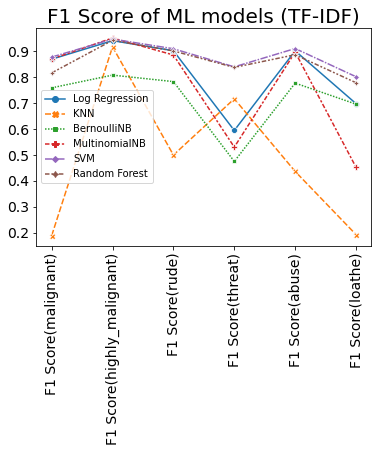

In [43]:
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

#### Note :- 
    For the evolution we consider the F1 score because we consider all the correctly identified cases .and in this scenario all the classes like TP,TN,FP,FN are equally important 

#### Observation :
    Overall across used different algorithms we are giving preference to SVC for prediction of comments .
    Because its providing us highest F1 score which is the highest line in purple color.also its have highest mean()
    compare to other algorithms.

In [44]:
#check with our test data

x = data_ma.comment_text
y = data_ma['malignant']



#clean text


malignant_comments = []

for sentence in tqdm(x.values):
    sentence = re.sub(r"http\S+","",sentence)
    sentence = BeautifulSoup(sentence,'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*","",sentence).strip()
    sentence = re.sub('[^A-Za-z-0-9]+',' ',sentence)
    sentence = re.sub(r'[^\x00-\x7f]',r' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
    malignant_comments.append(sentence.strip())



100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 700.76it/s]


In [45]:
#vectorized by using tfidf 

tf_idf = TfidfVectorizer(ngram_range=(1,1))

x_cleaned= tf_idf.fit_transform(malignant_comments)

#split train ,test
x_train, x_test, y_train, y_test = train_test_split(x_cleaned, y, test_size=0.3, random_state=0)
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
t = rf.predict(x_test)

print(accuracy_score(y_test,t)*100)

84.36666666666667


In [46]:
print(confusion_matrix(y_test,t))

print(f1_score(y_test,t))

[[1378  111]
 [ 358 1153]]
0.830990990990991


In [47]:
cv_score = cross_val_score(rf,x_cleaned,y,cv = 6)
cv_mean=cv_score.mean()
print(f"at cross foald {6} the cv score is {cv_mean} and accuracy for training is {accuracy_score(y_train,rf.predict(x_train))*100} and accurecy for testing is {accuracy_score(y_test,rf.predict(x_test))*100}")
print("\n")

at cross foald 6 the cv score is 0.8416002273734929 and accuracy for training is 99.95714285714286 and accurecy for testing is 84.36666666666667




In [48]:
#vectorized by using tfidf 

tf_idf = TfidfVectorizer(ngram_range=(1,1))

x_cleaned= tf_idf.fit_transform(malignant_comments)

#split train ,test
x_train, x_test, y_train, y_test = train_test_split(x_cleaned, y, test_size=0.3, random_state=0)

# x_train_fit = tf_idf.fit_transform(x_train)
# x_test_fit = tf_idf.transform(x_test)

sc = SVC()
sc.fit(x_train,y_train)
s = sc.predict(x_test)

print(accuracy_score(y_test,s)*100)



87.06666666666666


In [49]:
print(confusion_matrix(y_test,s))

print(f1_score(y_test,s))

[[1368  121]
 [ 267 1244]]
0.8650904033379693


In [50]:
cv_score = cross_val_score(sc,x_cleaned,y,cv = 6)
cv_mean=cv_score.mean()
print(f"at cross foald {6} the cv score is {cv_mean} and accuracy for training is {accuracy_score(y_train,sc.predict(x_train))*100} and accurecy for testing is {accuracy_score(y_test,sc.predict(x_test))*100}")
print("\n")

at cross foald 6 the cv score is 0.8757003101180484 and accuracy for training is 99.62857142857143 and accurecy for testing is 87.06666666666666


